# Exploratory data analysis (EDA)

Exploratory data analysis was conducted to characterize temporal dynamics, weather sensitivity, spatial heterogeneity, and distributional properties of demand. The results informed model selection, feature design, and the choice of modeling granularity.

## Temporal dynamics and seasonality

Temporal patterns were examined at the system level and for a representative sample of stations and clusters.

* Daily and hourly demand series were plotted over the 2017–2022 period.

  * Pre-COVID, COVID, and recovery periods were visually highlighted.
* Average daily profiles (hour-of-day curves) were computed and compared by:

  * Weekday versus weekend
  * Season (winter, spring, summer, autumn)
* Autocorrelation (ACF) and partial autocorrelation (PACF) functions were analyzed for the system-level series and selected stations to:

  * Identify strong daily and weekly seasonal patterns (lags at 24 and 7×24).
  * Motivate the inclusion of seasonal components in SARIMA- and Prophet-based models.

These analyses supported subsequent model design decisions and time series decomposition discussions.

## Weather and demand relationships

The relationship between weather conditions and demand was examined empirically.

* Scatter and heat plots of demand versus temperature were produced, with smoothing applied to illustrate non-linear comfort-range effects.
* Boxplots of demand were constructed across precipitation bins and AQI categories.
* Time series overlays were used to highlight extreme weather events and associated demand reductions.

These results illustrated the role of weather as an external forcing mechanism within the conceptual framework.

## Spatial heterogeneity

Spatial variation in demand was analyzed across stations and clusters.

* Maps of average daily demand per station were produced, including separate views for:

  * Morning versus evening peak periods
  * Weekdays versus weekends
* Demand distributions were compared across station clusters (residential, commercial, and transit-adjacent).
* Correlation analyses and simple regressions were conducted to assess relationships between demand and:

  * Population density
  * Employment density
  * Distance to the nearest subway station
  * Land-use mix

These findings motivated the use of station clustering and multilevel modeling approaches.

## Distribution and outliers

Distributional properties of demand were examined to assess modeling implications.

* The distribution of hourly demand per station was analyzed to identify sparsity, skewness, and the prevalence of zero values.
* Outlier detection was performed to identify days with extremely high or low demand and to distinguish between data quality issues and genuine events.
* The suitability of log transformations for selected targets was evaluated, particularly for station-level machine learning and deep learning models.

## Choosing modeling granularities

EDA results were used to justify modeling choices.

* The feasibility of hourly modeling was assessed across stations, including the application of minimum activity thresholds.
* The system-level daily series was identified as the primary benchmark for time series models, while station- and cluster-level hourly series were selected as the main focus for machine learning and deep learning models.

In [1]:
# Standard library
from pathlib import Path

# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
from matplotlib.lines import Line2D

# Statistical modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

# Geospatial
import contextily as cx
from pyproj import Transformer

In [2]:
# Cool-tone palette for non-regime line plots
COLOR_WEEKDAY = "#1F77B4"
COLOR_WEEKEND = "#2CA02C"

SEASON_ORDER = ["Winter", "Spring", "Summer", "Autumn"]

SEASON_COLORS = {
    "Winter": "#1F77B4",
    "Spring": "#2CA02C",
    "Summer": "#17BECF",
    "Autumn": "#9467BD"
}

In [3]:
BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

PATHS = {
    "y_daily_system": BASE / "targets/system/y_daily_system.parquet",
    "y_hourly_system": BASE / "targets/system/y_hourly_system.parquet",
    "cal_hourly": BASE / "calendar/calendar_hourly.parquet",
    "cal_daily": BASE / "calendar/calendar_daily.parquet",
    "y_daily_station": BASE / "targets/station/y_daily_station.parquet",
    "y_hourly_station": BASE / "targets/station/y_hourly_station.parquet",
    "station_clusters_k3": BASE / "targets/cluster/station_clusters_k3.parquet",
}

START = pd.Timestamp("2017-01-01")
END   = pd.Timestamp("2022-12-31 23:00:00")

# High-contrast categorical palette for regimes
REGIME_CMAP = cm.get_cmap("tab10")
LINEWIDTH_SYSTEM_D = 1.0
LINEWIDTH_SYSTEM_H = 0.6
LINEWIDTH_STATION_D = 0.9
LINEWIDTH_STATION_H = 0.6

def add_season_from_month(df, month_col="month"):
    m = df[month_col].astype(int)
    season = pd.Series(index=df.index, dtype="object")
    season[m.isin([12, 1, 2])] = "Winter"
    season[m.isin([3, 4, 5])] = "Spring"
    season[m.isin([6, 7, 8])] = "Summer"
    season[m.isin([9, 10, 11])] = "Autumn"
    out = df.copy()
    out["season"] = season
    return out

def build_regime_color_map_from_calendar(cal, time_col, regime_col="pandemic_regime"):
    c = cal[[time_col, regime_col]].dropna().sort_values(time_col).copy()
    labels = list(pd.unique(c[regime_col].astype("object")))

    COOL_PALETTE = [
        "#1F77B4",
        "#2CA02C",
        "#17BECF",
        "#9467BD"
    ]

    return {
        lbl: COOL_PALETTE[i % len(COOL_PALETTE)]
        for i, lbl in enumerate(labels)
    }

def plot_line_shaded_by_regime(ax, df, x_col, y_col, regime_col, regime_color_map, linewidth=1.0):
    d = df[[x_col, y_col, regime_col]].dropna().sort_values(x_col).copy()

    # New segment whenever regime changes
    seg_id = (d[regime_col] != d[regime_col].shift()).cumsum()
    for _, seg in d.groupby(seg_id):
        lbl = seg[regime_col].iloc[0]
        ax.plot(seg[x_col], seg[y_col], linewidth=linewidth, color=regime_color_map.get(lbl, "black"))

REGIME_LABELS = {
    "other": "Other",
    "pre_covid": "Pre-Covid",
    "covid": "Covid",
    "recovery": "Recovery",
}

def add_regime_legend(ax, regime_color_map, title=None):
    handles = []
    labels = []

    for regime, color in regime_color_map.items():
        handles.append(
            plt.Line2D([0], [0], color=color, linewidth=3)
        )
        labels.append(REGIME_LABELS.get(regime, regime))

    ax.legend(handles, labels, title=title)

/var/folders/lm/tx5m_rsx42d8dp9md2z_by1m0000gn/T/ipykernel_14448/2501838851.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  REGIME_CMAP = cm.get_cmap("tab10")


In [4]:
# Load system series
y_daily_sys = pd.read_parquet(PATHS["y_daily_system"])
y_daily_sys["date"] = pd.to_datetime(y_daily_sys["date"])
y_daily_sys = y_daily_sys[(y_daily_sys["date"] >= START) & (y_daily_sys["date"] <= END.normalize())].copy()

y_hourly_sys = pd.read_parquet(PATHS["y_hourly_system"])
y_hourly_sys["ts_hour"] = pd.to_datetime(y_hourly_sys["ts_hour"])
y_hourly_sys = y_hourly_sys[(y_hourly_sys["ts_hour"] >= START) & (y_hourly_sys["ts_hour"] <= END)].copy()

# Load calendars
cal_h = pd.read_parquet(PATHS["cal_hourly"])
cal_h["ts_hour"] = pd.to_datetime(cal_h["ts_hour"])
cal_h = cal_h[(cal_h["ts_hour"] >= START) & (cal_h["ts_hour"] <= END)].copy()

cal_d = pd.read_parquet(PATHS["cal_daily"])
cal_d["date"] = pd.to_datetime(cal_d["date"])
cal_d = cal_d[(cal_d["date"] >= START) & (cal_d["date"] <= END.normalize())].copy()

# Join regime labels
y_daily_sys = y_daily_sys.merge(cal_d[["date", "pandemic_regime"]], on="date", how="left")
y_hourly_sys = y_hourly_sys.merge(cal_h[["ts_hour", "pandemic_regime"]], on="ts_hour", how="left")

# Regime color maps (consistent order taken from the calendar)
daily_regime_colors  = build_regime_color_map_from_calendar(cal_d, time_col="date", regime_col="pandemic_regime")
hourly_regime_colors = build_regime_color_map_from_calendar(cal_h, time_col="ts_hour", regime_col="pandemic_regime")

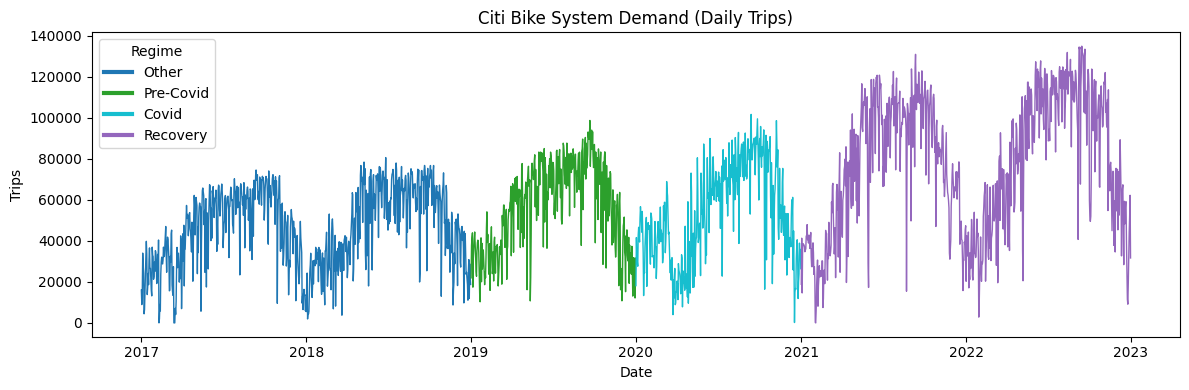

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_line_shaded_by_regime(
    ax, y_daily_sys, x_col="date", y_col="trips",
    regime_col="pandemic_regime", regime_color_map=daily_regime_colors,
    linewidth=LINEWIDTH_SYSTEM_D
)
ax.set_title("Citi Bike System Demand (Daily Trips)")
ax.set_xlabel("Date")
ax.set_ylabel("Trips")
add_regime_legend(ax, daily_regime_colors, title="Regime")
plt.tight_layout()
plt.show()

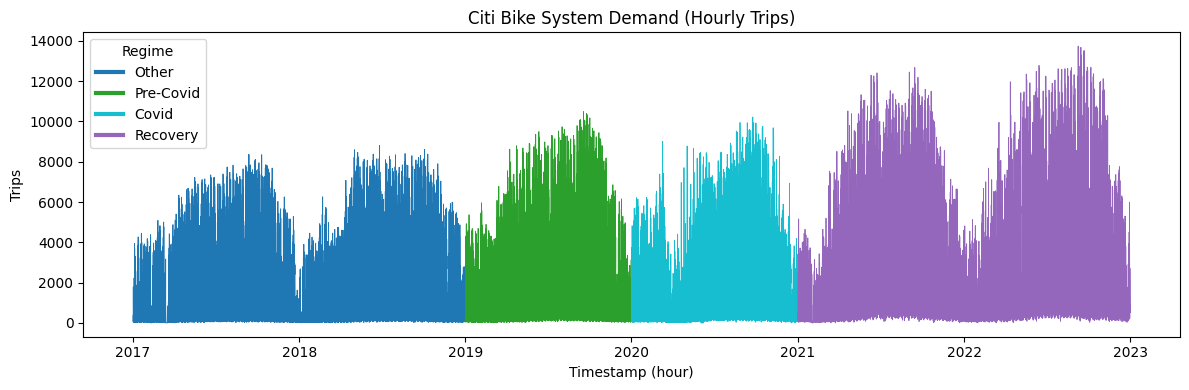

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_line_shaded_by_regime(
    ax, y_hourly_sys, x_col="ts_hour", y_col="trips",
    regime_col="pandemic_regime", regime_color_map=hourly_regime_colors,
    linewidth=LINEWIDTH_SYSTEM_H
)
ax.set_title("Citi Bike System Demand (Hourly Trips)")
ax.set_xlabel("Timestamp (hour)")
ax.set_ylabel("Trips")
add_regime_legend(ax, hourly_regime_colors, title="Regime")
plt.tight_layout()
plt.show()

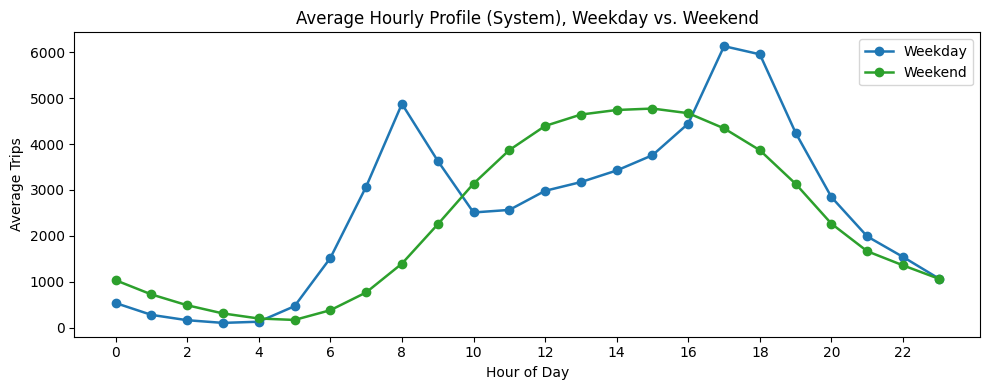

In [7]:
sys_h = y_hourly_sys.copy()
sys_h = add_season_from_month(sys_h, month_col="month")

profile_wk = (
    sys_h.groupby(["is_weekend", "hour"], as_index=False)["trips"]
         .mean()
         .sort_values(["is_weekend", "hour"])
)

fig, ax = plt.subplots(figsize=(10, 4))

for is_wknd, g in profile_wk.groupby("is_weekend"):
    if bool(is_wknd):
        label = "Weekend"
        color = COLOR_WEEKEND
    else:
        label = "Weekday"
        color = COLOR_WEEKDAY

    ax.plot(g["hour"], g["trips"], marker="o", linewidth=1.8, label=label, color=color)

ax.set_title("Average Hourly Profile (System), Weekday vs. Weekend")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Trips")
ax.set_xticks(range(0, 24, 2))
ax.legend()
plt.tight_layout()
plt.show()

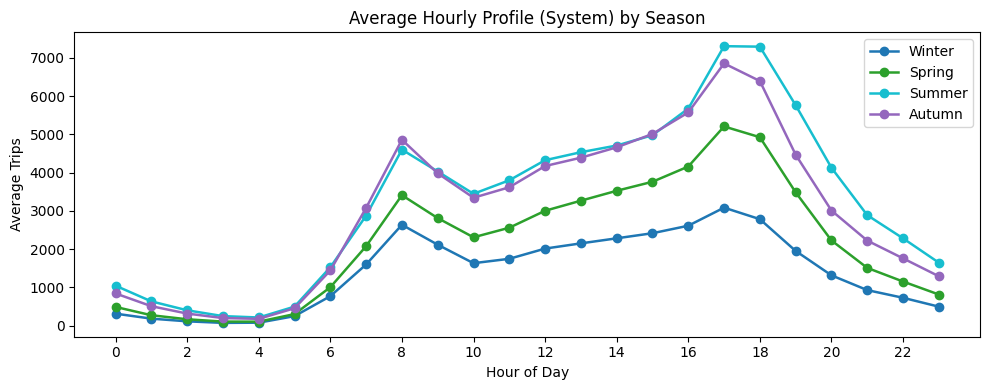

In [8]:
profile_season = (
    sys_h.groupby(["season", "hour"], as_index=False)["trips"]
         .mean()
)

fig, ax = plt.subplots(figsize=(10, 4))

for season in SEASON_ORDER:
    g = profile_season[profile_season["season"] == season]
    if g.empty:
        continue

    ax.plot(
        g["hour"],
        g["trips"],
        marker="o",
        linewidth=1.8,
        color=SEASON_COLORS[season],
        label=season
    )

ax.set_title("Average Hourly Profile (System) by Season")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Trips")
ax.set_xticks(range(0, 24, 2))
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# Inputs
clusters = pd.read_parquet(PATHS["station_clusters_k3"])[["station_id", "cluster_id", "cluster_label"]]

y_daily_st = pd.read_parquet(PATHS["y_daily_station"])
y_daily_st["date"] = pd.to_datetime(y_daily_st["date"])
y_daily_st = y_daily_st[(y_daily_st["date"] >= START) & (y_daily_st["date"] <= END.normalize())].copy()

cal_d = pd.read_parquet(PATHS["cal_daily"])
cal_d["date"] = pd.to_datetime(cal_d["date"])
cal_d = cal_d[(cal_d["date"] >= START) & (cal_d["date"] <= END.normalize())].copy()

# Build per-station observed date sets
obs_dates = (
    y_daily_st.groupby("station_id")["date"]
    .apply(lambda s: pd.Index(pd.to_datetime(s).unique()))
)

# Basic station stats
station_stats = (
    y_daily_st.groupby("station_id", as_index=False)
    .agg(first_date=("date", "min"),
         last_date=("date", "max"),
         n_obs_days=("date", "nunique"),
         total_departures=("departures", "sum"))
)

# Continuity metrics computed on the full daily span between first and last date
def continuity_metrics(row):
    sid = row["station_id"]
    first = row["first_date"]
    last = row["last_date"]

    # Full daily span length (days)
    span_days = int((last - first).days) + 1
    if span_days <= 0:
        return pd.Series({"span_days": 0, "coverage_ratio": 0.0, "max_gap_days": np.inf})

    # Calendar days in
    span_idx = cal_d[(cal_d["date"] >= first) & (cal_d["date"] <= last)]["date"]
    span_days = int(span_idx.shape[0])

    # Observed within that span
    observed = obs_dates.loc[sid]
    observed_in_span = observed.intersection(span_idx)

    coverage_ratio = float(len(observed_in_span) / span_days) if span_days > 0 else 0.0

    # Max gap
    d = np.sort(pd.to_datetime(observed_in_span).to_numpy())
    if d.size <= 1:
        max_gap = np.inf
    else:
        diffs = np.diff(d).astype("timedelta64[D]").astype(int)
        max_gap = int(np.max(diffs) - 1)

    return pd.Series({"span_days": span_days, "coverage_ratio": coverage_ratio, "max_gap_days": max_gap})

metrics = station_stats.apply(continuity_metrics, axis=1)
station_stats = pd.concat([station_stats, metrics], axis=1)

# Join clusters
cov_cl = station_stats.merge(clusters, on="station_id", how="inner")

# Constraints tuned for continuous use
MIN_SPAN_DAYS = 365 * 3
MIN_COVERAGE_RATIO = 0.97
MAX_GAP_DAYS = 14

cov_cl["eligible"] = (
    (cov_cl["span_days"] >= MIN_SPAN_DAYS) &
    (cov_cl["coverage_ratio"] >= MIN_COVERAGE_RATIO) &
    (cov_cl["max_gap_days"] <= MAX_GAP_DAYS)
)

chosen = []
for (cid, clabel), g in cov_cl.groupby(["cluster_id", "cluster_label"]):
    g1 = g[g["eligible"]].copy()
    if len(g1) > 0:
        pick = g1.sort_values("total_departures", ascending=False).head(1)
    else:
        pick = g.sort_values(
            ["coverage_ratio", "max_gap_days", "span_days", "total_departures"],
            ascending=[False, True, False, False]
        ).head(1)
    chosen.append(pick)

sample_stations = pd.concat(chosen, ignore_index=True)[
    ["cluster_id", "cluster_label", "station_id",
     "first_date", "last_date", "span_days", "n_obs_days", "coverage_ratio", "max_gap_days"]
]

sample_station_ids = sample_stations["station_id"].tolist()
sample_stations

cluster_id     cluster_label station_id first_date  last_date  span_days  \
0           0       residential    5489.03 2020-01-01 2022-12-31     1096.0   
1           1        commercial    6140.05 2020-01-01 2022-12-31     1096.0   
2           2  transit_adjacent    6429.01 2020-01-01 2022-12-31     1096.0   

   n_obs_days  coverage_ratio  max_gap_days  
0        1072        0.978102          10.0  
1        1094        0.998175           2.0  
2        1085        0.989964           3.0

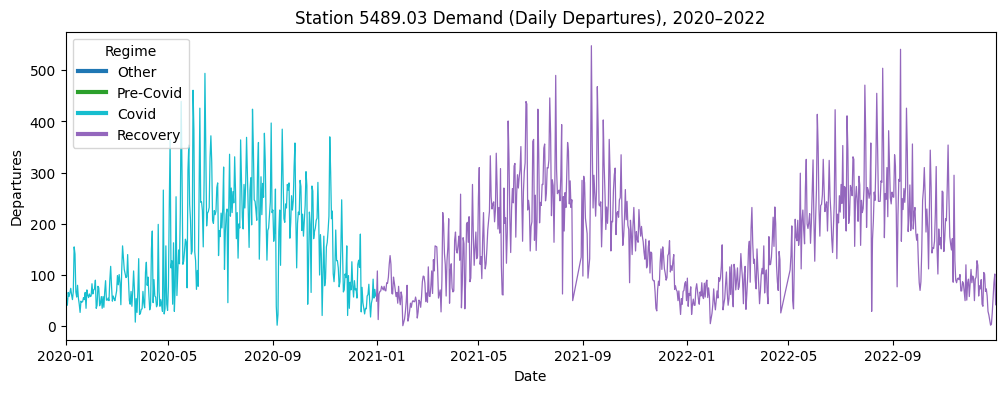

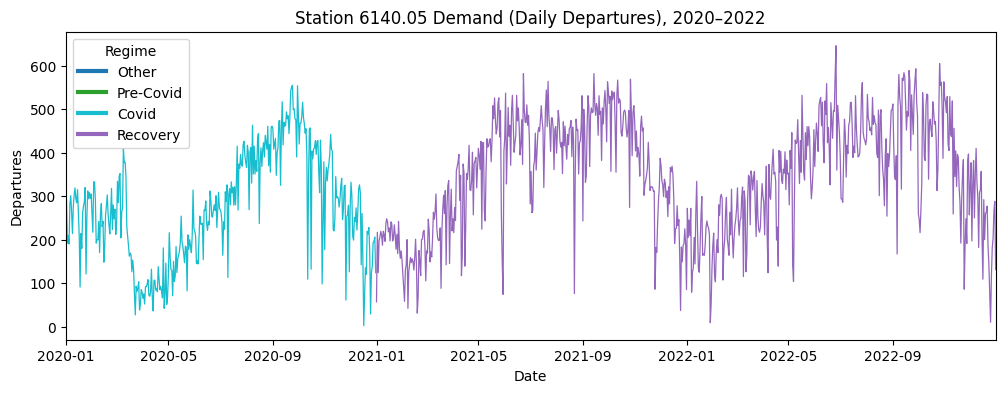

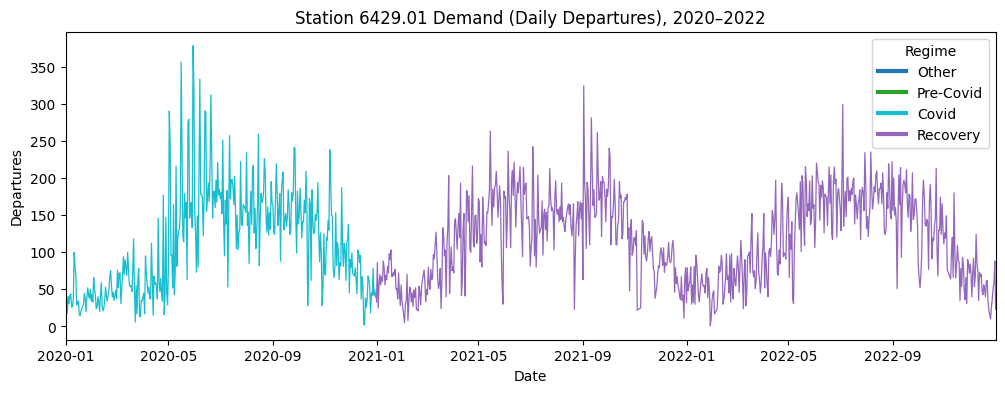

In [10]:
st_daily = (
    y_daily_st[y_daily_st["station_id"].isin(sample_station_ids)]
    .merge(cal_d[["date", "pandemic_regime"]], on="date", how="left")
)

for sid in sample_station_ids:
    g = st_daily[st_daily["station_id"] == sid].sort_values("date")

    # Limit x-range to years where the station has data
    xmin = g["date"].min()
    xmax = g["date"].max()

    fig, ax = plt.subplots(figsize=(12, 4))
    plot_line_shaded_by_regime(
        ax, g, x_col="date", y_col="departures",
        regime_col="pandemic_regime", regime_color_map=daily_regime_colors,
        linewidth=LINEWIDTH_STATION_D
    )
    ax.set_xlim(xmin, xmax)

    ax.set_title(f"Station {sid} Demand (Daily Departures), {xmin.year}–{xmax.year}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Departures")
    add_regime_legend(ax, daily_regime_colors, title="Regime")
    plt.show()

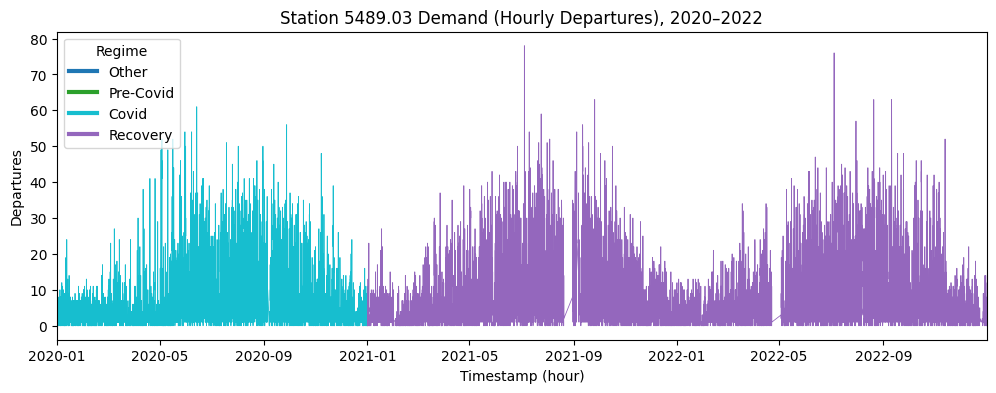

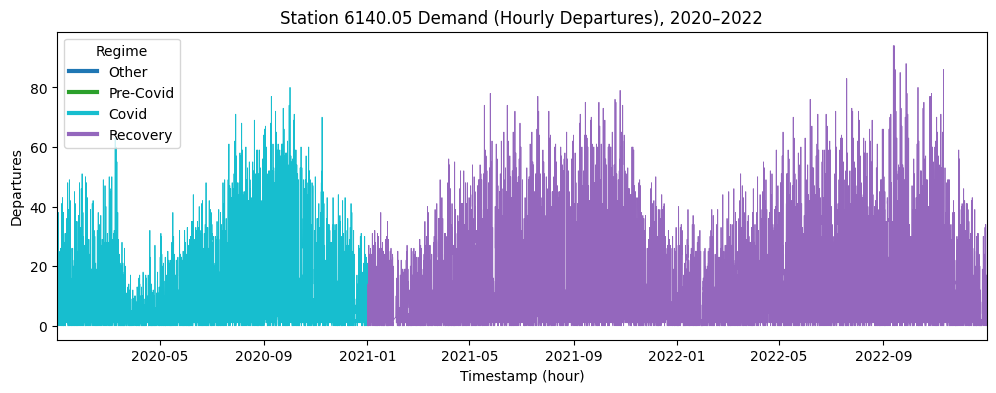

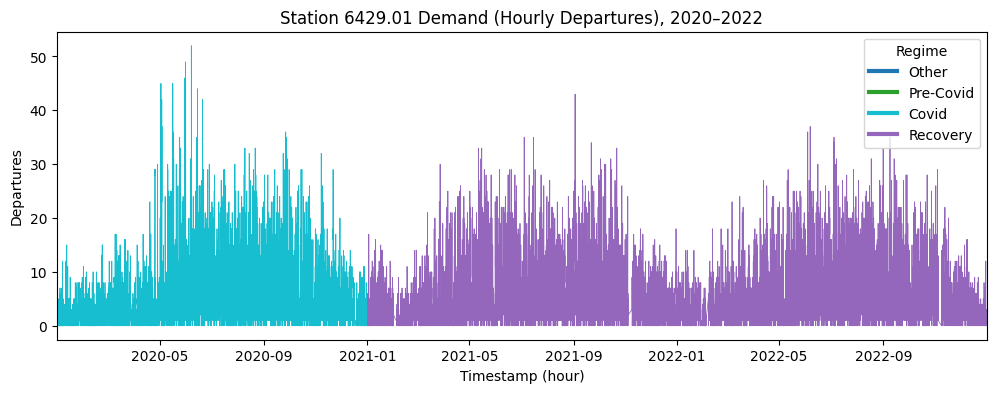

In [11]:
usecols = ["ts_hour", "station_id", "departures"]
y_hourly_st = pd.read_parquet(PATHS["y_hourly_station"], columns=usecols)
y_hourly_st["ts_hour"] = pd.to_datetime(y_hourly_st["ts_hour"])

st_hourly = y_hourly_st[
    (y_hourly_st["ts_hour"] >= START) &
    (y_hourly_st["ts_hour"] <= END) &
    (y_hourly_st["station_id"].isin(sample_station_ids))
].copy()

st_hourly = st_hourly.merge(
    cal_h[["ts_hour", "hour", "month", "is_weekend", "pandemic_regime"]],
    on="ts_hour",
    how="left"
)
st_hourly = add_season_from_month(st_hourly, month_col="month")

for sid in sample_station_ids:
    g = st_hourly[st_hourly["station_id"] == sid].sort_values("ts_hour")

    xmin = g["ts_hour"].min()
    xmax = g["ts_hour"].max()

    fig, ax = plt.subplots(figsize=(12, 4))
    plot_line_shaded_by_regime(
        ax, g, x_col="ts_hour", y_col="departures",
        regime_col="pandemic_regime", regime_color_map=hourly_regime_colors,
        linewidth=LINEWIDTH_STATION_H
    )
    ax.set_xlim(xmin, xmax)

    ax.set_title(f"Station {sid} Demand (Hourly Departures), {xmin.year}–{xmax.year}")
    ax.set_xlabel("Timestamp (hour)")
    ax.set_ylabel("Departures")
    add_regime_legend(ax, hourly_regime_colors, title="Regime")
    plt.show()

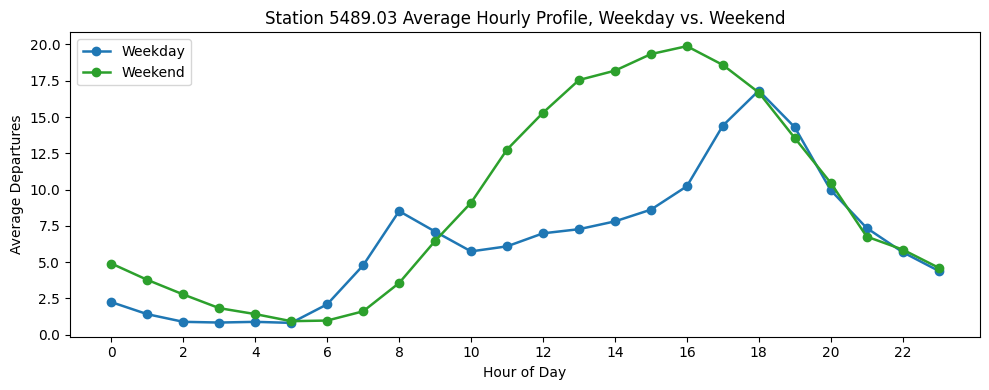

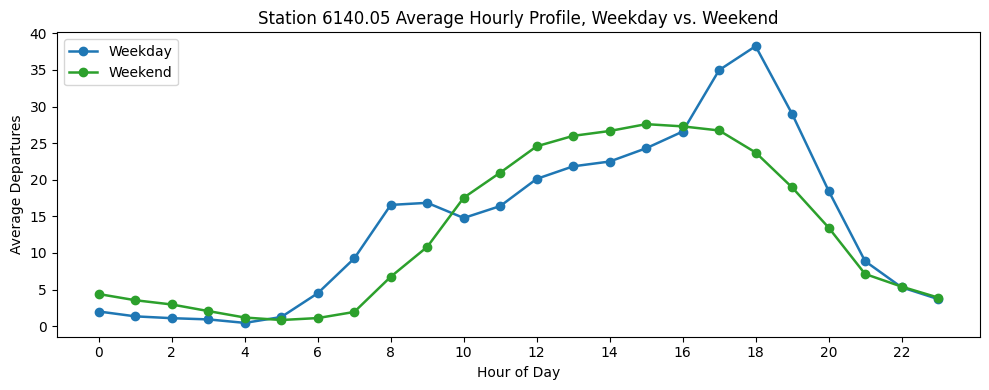

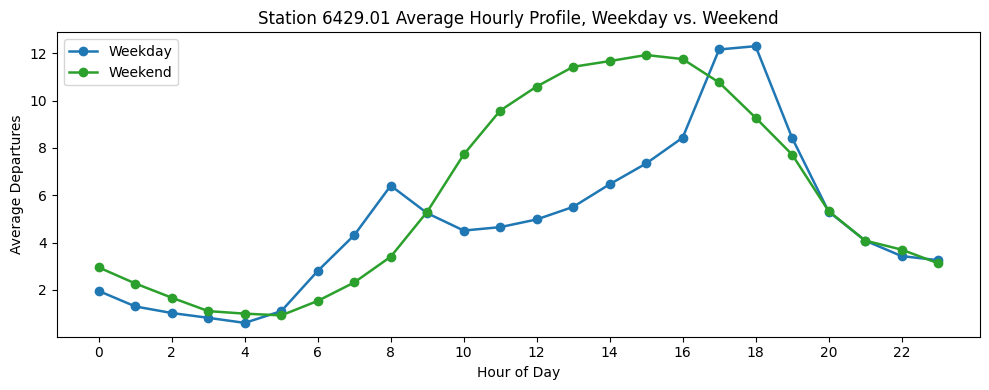

In [12]:
for sid in sample_station_ids:
    g = st_hourly[st_hourly["station_id"] == sid].copy()
    prof = g.groupby(["is_weekend", "hour"], as_index=False)["departures"].mean()

    fig, ax = plt.subplots(figsize=(10, 4))
    for is_wknd, gg in prof.groupby("is_weekend"):
        if bool(is_wknd):
            label = "Weekend"
            color = COLOR_WEEKEND
        else:
            label = "Weekday"
            color = COLOR_WEEKDAY

        ax.plot(
            gg["hour"], gg["departures"],
            marker="o", linewidth=1.8,
            label=label, color=color
        )

    ax.set_title(f"Station {sid} Average Hourly Profile, Weekday vs. Weekend")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Average Departures")
    ax.set_xticks(range(0, 24, 2))
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

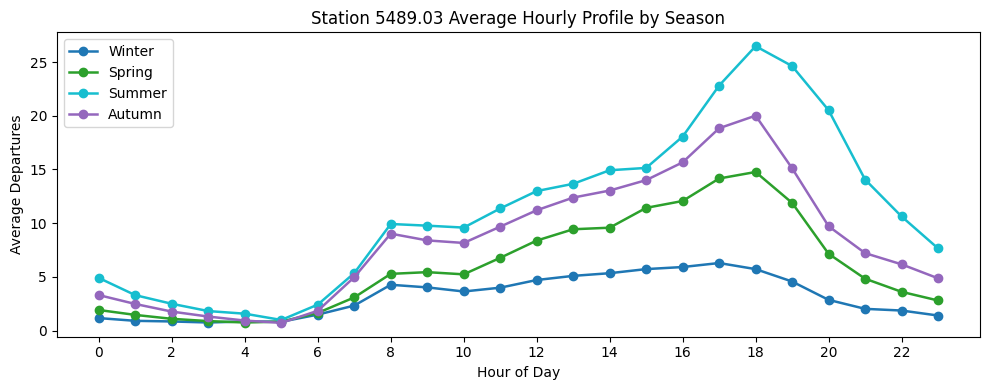

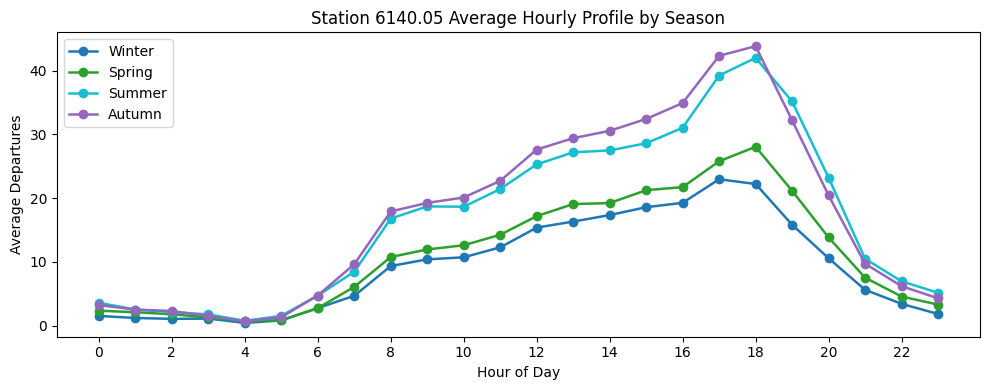

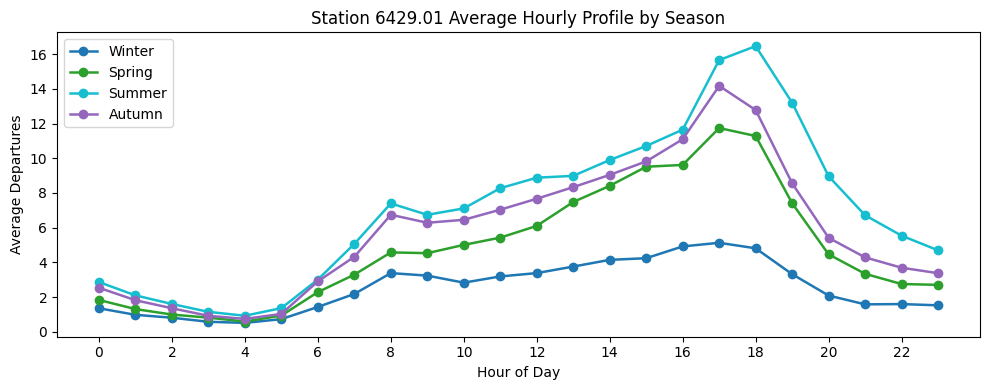

In [13]:
for sid in sample_station_ids:
    g = st_hourly[st_hourly["station_id"] == sid].copy()

    prof = (
        g.groupby(["season", "hour"], as_index=False)["departures"]
         .mean()
    )

    fig, ax = plt.subplots(figsize=(10, 4))

    plotted_any = False
    for season in SEASON_ORDER:
        gg = prof[prof["season"] == season]
        if gg.empty:
            continue

        ax.plot(
            gg["hour"],
            gg["departures"],
            marker="o",
            linewidth=1.8,
            color=SEASON_COLORS[season],
            label=season
        )
        plotted_any = True

    ax.set_title(f"Station {sid} Average Hourly Profile by Season")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Average Departures")
    ax.set_xticks(range(0, 24, 2))
    if plotted_any:
        ax.legend(loc="upper left")
    else:
        print(f"Warning: no seasonal data plotted for station {sid}. Check st_hourly['season'] values and merges.")
    plt.tight_layout()
    plt.show()

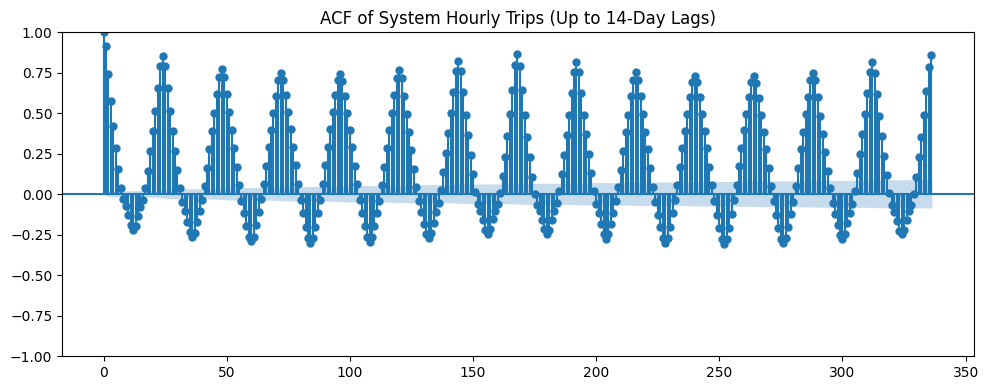

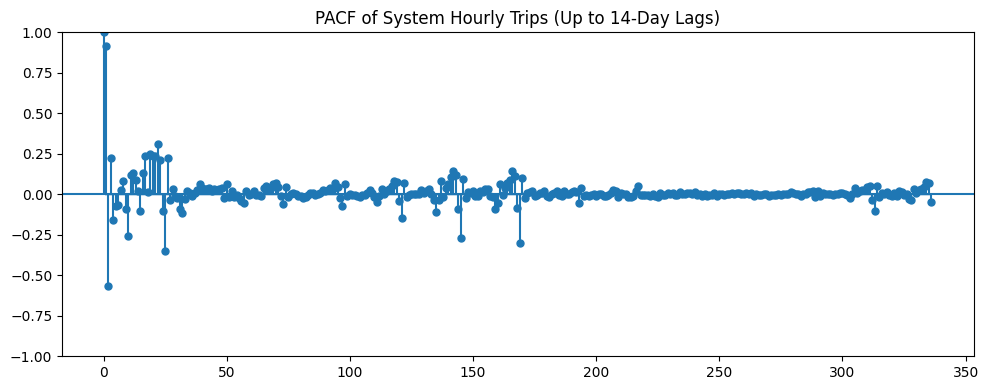

Seasonal lags to note: 24 (daily), 168 (weekly).


In [14]:
s_sys = y_hourly_sys.sort_values("ts_hour").set_index("ts_hour")["trips"].asfreq("h")

fig = plt.figure(figsize=(10, 4))
plot_acf(s_sys.dropna(), lags=24*14, ax=plt.gca())
plt.title("ACF of System Hourly Trips (Up to 14-Day Lags)")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 4))
plot_pacf(s_sys.dropna(), lags=24*14, ax=plt.gca(), method="ywm")
plt.title("PACF of System Hourly Trips (Up to 14-Day Lags)")
plt.tight_layout()
plt.show()

print("Seasonal lags to note: 24 (daily), 168 (weekly).")

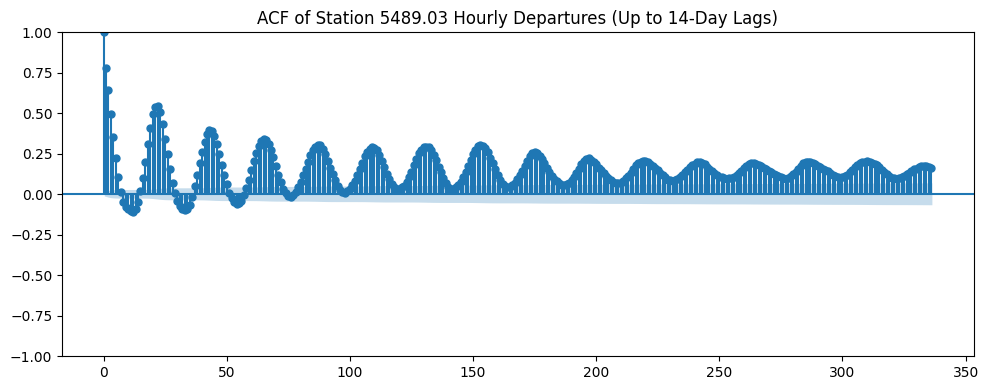

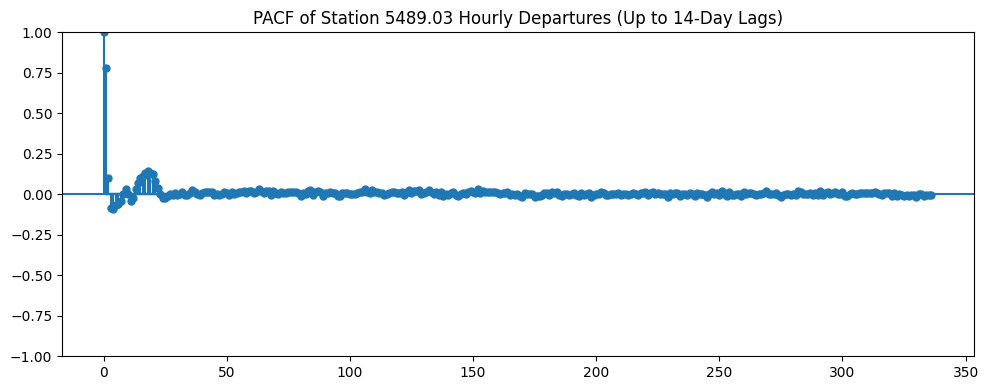

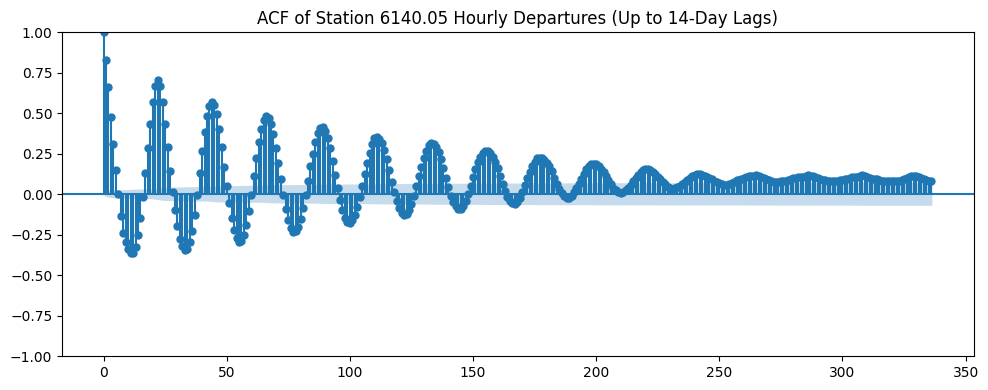

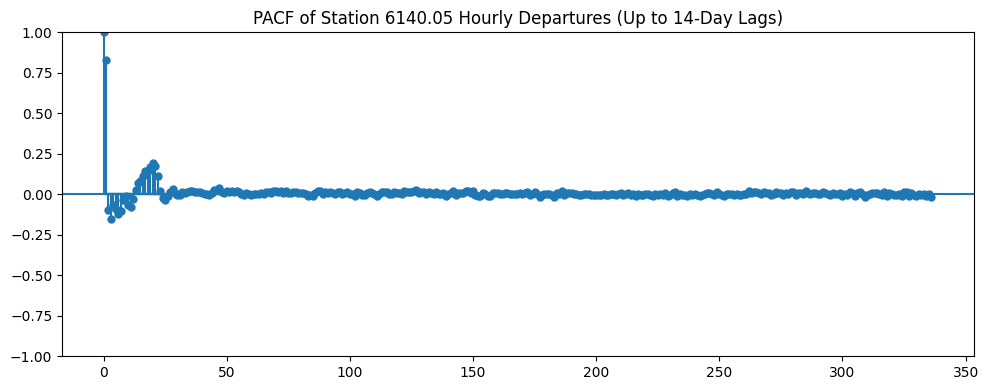

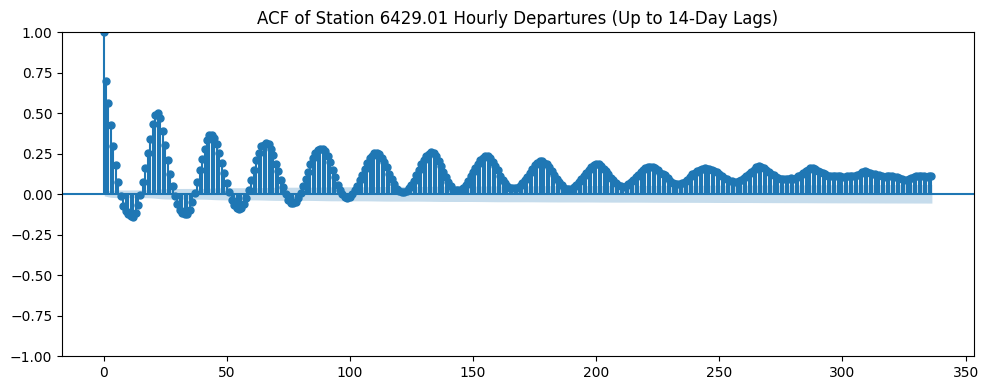

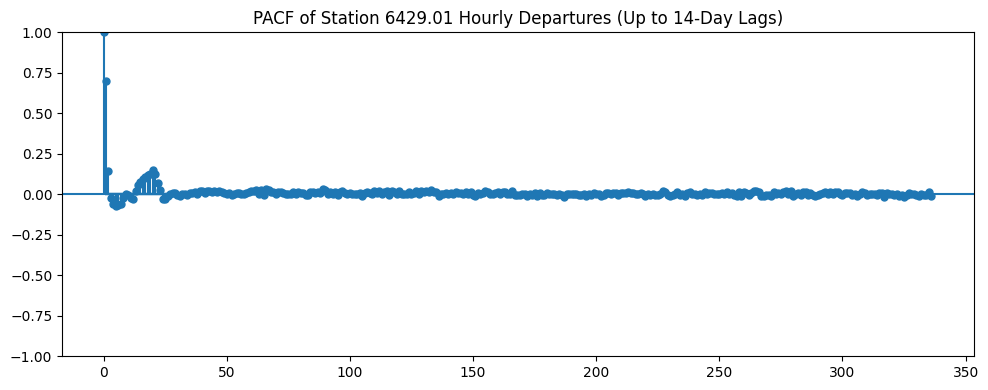

In [15]:
for sid in sample_station_ids:
    s = (
        st_hourly[st_hourly["station_id"] == sid]
        .sort_values("ts_hour")
        .set_index("ts_hour")["departures"]
        .asfreq("h")
    )

    fig = plt.figure(figsize=(10, 4))
    plot_acf(s.dropna(), lags=24*14, ax=plt.gca())
    plt.title(f"ACF of Station {sid} Hourly Departures (Up to 14-Day Lags)")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 4))
    plot_pacf(s.dropna(), lags=24*14, ax=plt.gca(), method="ywm")
    plt.title(f"PACF of Station {sid} Hourly Departures (Up to 14-Day Lags)")
    plt.tight_layout()
    plt.show()

In [16]:
BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

PATHS = {
    "X_hourly_system": BASE / "features/system/X_hourly_system.parquet",
    "X_daily_system":  BASE / "features/system/X_daily_system.parquet",
    "X_daily_station": BASE / "features/station/X_daily_station.parquet",
    "X_hourly_station_y": lambda y: BASE / f"features/station/hourly/X_hourly_station_{y}.parquet",
}

START = pd.Timestamp("2017-01-01")
END_D = pd.Timestamp("2022-12-31")
END_H = pd.Timestamp("2022-12-31 23:00:00")

C_BLUE   = "#1F77B4"
C_GREEN  = "#2CA02C"
C_CYAN   = "#17BECF"
C_PURPLE = "#9467BD"

COLOR_SCATTER = C_CYAN
COLOR_SMOOTH  = C_PURPLE
COLOR_TS      = C_BLUE
COLOR_EXTREME = C_GREEN

In [17]:
Xh = pd.read_parquet(PATHS["X_hourly_system"])
Xd = pd.read_parquet(PATHS["X_daily_system"])

Xh["ts_hour"] = pd.to_datetime(Xh["ts_hour"])
Xd["date"] = pd.to_datetime(Xd["date"])

Xh = Xh[(Xh["ts_hour"] >= START) & (Xh["ts_hour"] <= END_H)].copy()
Xd = Xd[(Xd["date"] >= START) & (Xd["date"] <= END_D)].copy()

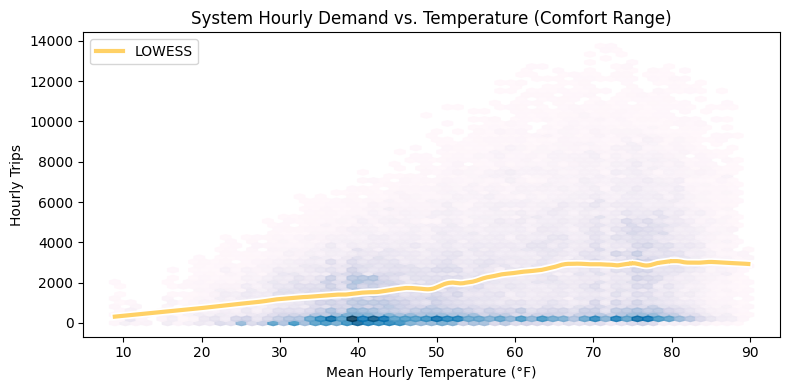

In [18]:
df = Xh[["temp_avg_f", "trips"]].dropna().copy()
x = df["temp_avg_f"].astype(float).to_numpy()
y = df["trips"].astype(float).to_numpy()

smooth = lowess(y, x, frac=0.08, return_sorted=True)

fig, ax = plt.subplots(figsize=(8, 4))

hb = ax.hexbin(
    x, y,
    gridsize=60,
    mincnt=1,
    cmap="PuBu",
    alpha=0.85
)

# LOWESS line
line, = ax.plot(
    smooth[:, 0], smooth[:, 1],
    linewidth=3.0,
    color="#FFD166",
    label="LOWESS"
)
line.set_path_effects([
    pe.Stroke(linewidth=5.5, foreground="white"),
    pe.Normal()
])

ax.set_title("System Hourly Demand vs. Temperature (Comfort Range)")
ax.set_xlabel("Mean Hourly Temperature (°F)")
ax.set_ylabel("Hourly Trips")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

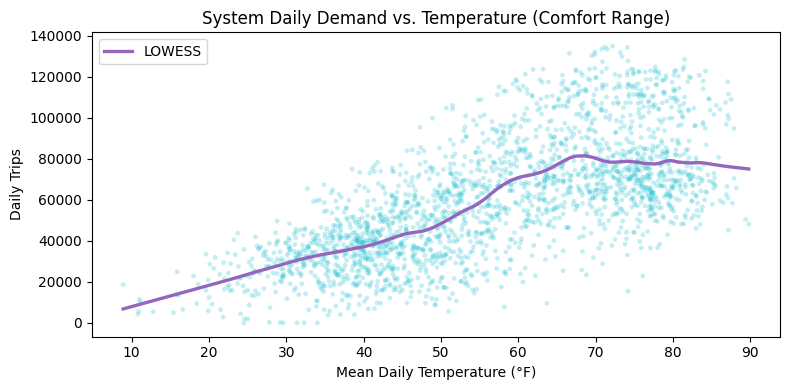

In [19]:
df = Xd[["temp_avg_f", "trips"]].dropna().copy()

x = df["temp_avg_f"].astype(float).to_numpy()
y = df["trips"].astype(float).to_numpy()

smooth = lowess(y, x, frac=0.15, return_sorted=True)

fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(x, y, s=12, alpha=0.25, color=COLOR_SCATTER, edgecolors="none")
ax.plot(smooth[:, 0], smooth[:, 1], linewidth=2.4, color=COLOR_SMOOTH, label="LOWESS")

ax.set_title("System Daily Demand vs. Temperature (Comfort Range)")
ax.set_xlabel("Mean Daily Temperature (°F)")
ax.set_ylabel("Daily Trips")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

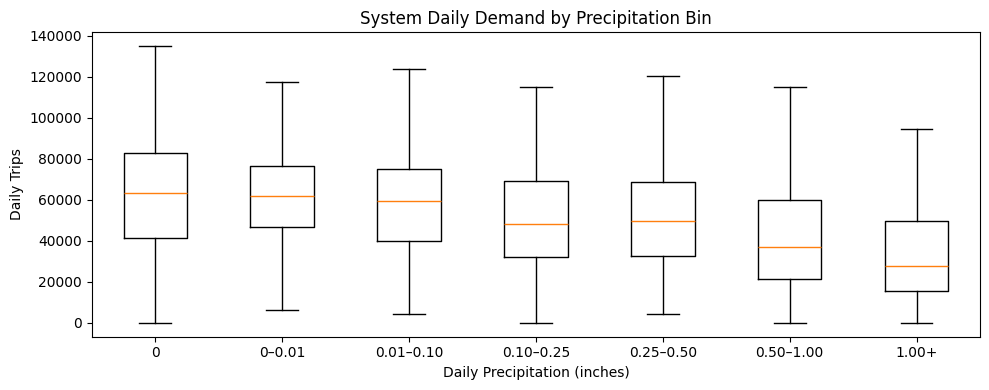

In [20]:
df = Xd[["trips", "precip_inches"]].dropna().copy()

# Bins tuned for interpretability
bins = [-0.001, 0.0, 0.01, 0.10, 0.25, 0.50, 1.00, np.inf]
labels = ["0", "0–0.01", "0.01–0.10", "0.10–0.25", "0.25–0.50", "0.50–1.00", "1.00+"]

df["precip_bin"] = pd.cut(df["precip_inches"], bins=bins, labels=labels)

data = [df.loc[df["precip_bin"] == lab, "trips"].to_numpy() for lab in labels]

fig, ax = plt.subplots(figsize=(10, 4))
bp = ax.boxplot(data, tick_labels=labels, showfliers=False)

ax.set_title("System Daily Demand by Precipitation Bin")
ax.set_xlabel("Daily Precipitation (inches)")
ax.set_ylabel("Daily Trips")
plt.tight_layout()
plt.show()

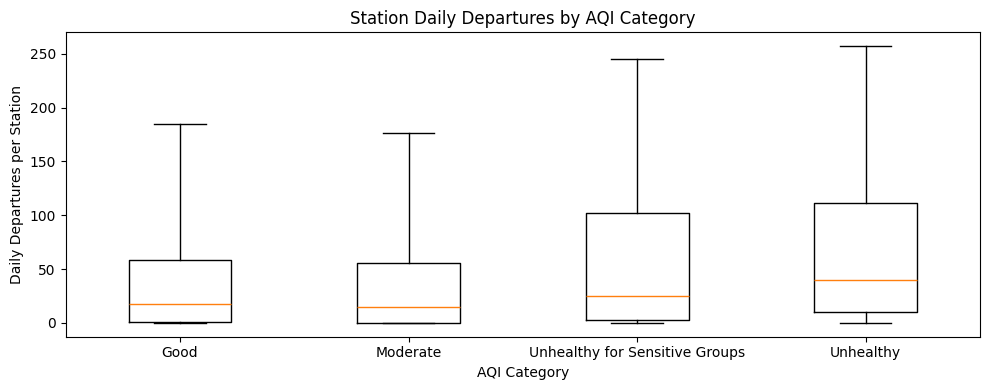

In [21]:
Xs_d = pd.read_parquet(PATHS["X_daily_station"])
Xs_d["date"] = pd.to_datetime(Xs_d["date"])
Xs_d = Xs_d[(Xs_d["date"] >= START) & (Xs_d["date"] <= END_D)].copy()

df = Xs_d[["departures", "aqi_category"]].dropna().copy()

cat_order = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]
present = [c for c in cat_order if c in df["aqi_category"].unique()]
if len(present) == 0:
    present = sorted(df["aqi_category"].unique())

data = [df.loc[df["aqi_category"] == c, "departures"].to_numpy() for c in present]

fig, ax = plt.subplots(figsize=(10, 4))

bp = ax.boxplot(
    data,
    tick_labels=present,
    showfliers=False,
    whis=(5, 95)
)

ax.set_title("Station Daily Departures by AQI Category")
ax.set_xlabel("AQI Category")
ax.set_ylabel("Daily Departures per Station")
plt.tight_layout()
plt.show()

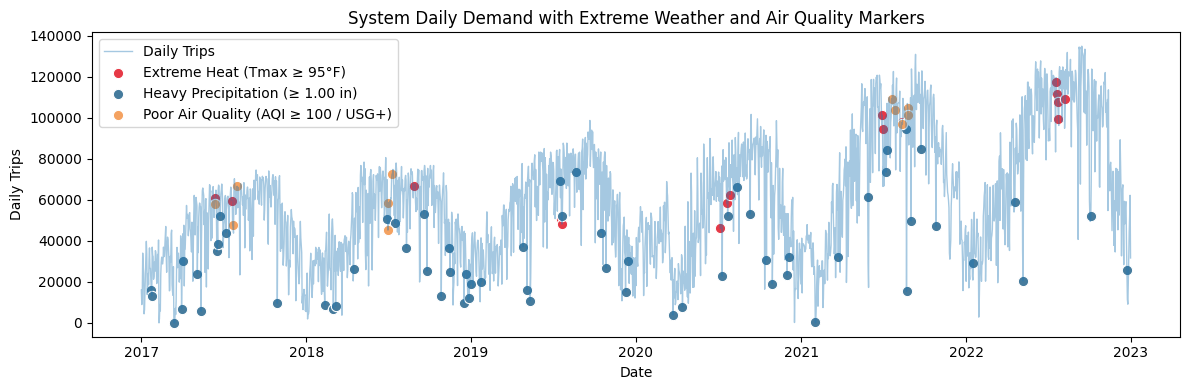

In [22]:
# Build df safely
df = Xd[[
    "date", "trips", "temp_max_f", "precip_inches", "aqi_citywide",
    "aqi_city_usg_or_worse", "aqi_city_unhealthy_or_worse"
]].copy()

# Ensure datetime ordering
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    x = df["date"]
else:
    df = df.sort_index()
    x = df.index

HEAT_F = 95.0
HEAVY_RAIN_IN = 1.00
AQI_HIGH = 100.0

# Event flags
df["extreme_heat"] = df["temp_max_f"].ge(HEAT_F)
df["heavy_precip"] = df["precip_inches"].ge(HEAVY_RAIN_IN)

if "aqi_city_usg_or_worse" in df.columns and df["aqi_city_usg_or_worse"].notna().any():
    df["bad_aqi"] = df["aqi_city_usg_or_worse"].astype(bool)
else:
    df["bad_aqi"] = df["aqi_citywide"].ge(AQI_HIGH)

fig, ax = plt.subplots(figsize=(12, 4))

# Context line
ax.plot(
    x, df["trips"],
    linewidth=1.0,
    alpha=0.40,
    color=C_BLUE,
    label="Daily Trips"
)

ax.scatter(
    x[df["extreme_heat"]],
    df.loc[df["extreme_heat"], "trips"],
    s=55, marker="o",
    color="#E63946", edgecolors="white", linewidths=0.8,
    label=f"Extreme Heat (Tmax ≥ {HEAT_F:.0f}°F)"
)

ax.scatter(
    x[df["heavy_precip"]],
    df.loc[df["heavy_precip"], "trips"],
    s=55, marker="o",
    color="#457B9D", edgecolors="white", linewidths=0.8,
    label=f"Heavy Precipitation (≥ {HEAVY_RAIN_IN:.2f} in)"
)

ax.scatter(
    x[df["bad_aqi"]],
    df.loc[df["bad_aqi"], "trips"],
    s=55, marker="o",
    color="#F4A261", edgecolors="white", linewidths=0.8,
    label="Poor Air Quality (AQI ≥ 100 / USG+)"
)

ax.set_title("System Daily Demand with Extreme Weather and Air Quality Markers")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Trips")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

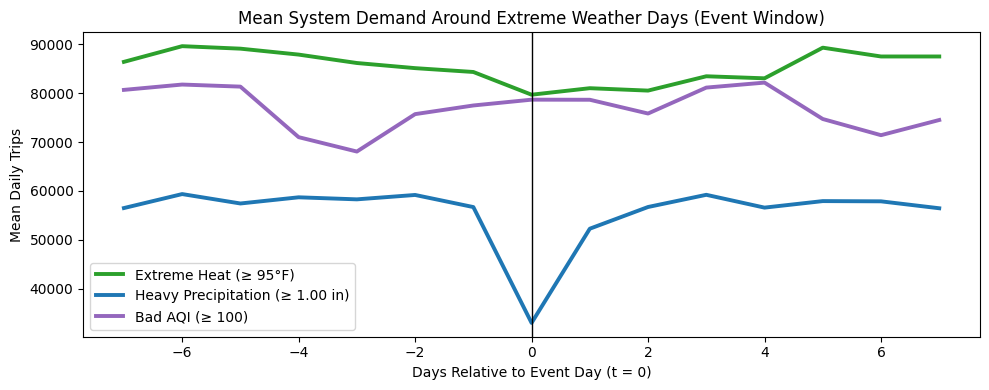

In [23]:
df = Xd[["date", "trips", "temp_max_f", "precip_inches", "aqi_citywide", "aqi_city_usg_or_worse"]].dropna(subset=["date", "trips"]).copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

HEAT_F = 95.0
HEAVY_RAIN_IN = 1.00
AQI_HIGH = 100.0
WINDOW = 7

ext_heat_days = df.index[df["temp_max_f"].ge(HEAT_F)]
ext_rain_days = df.index[df["precip_inches"].ge(HEAVY_RAIN_IN)]

if "aqi_city_usg_or_worse" in df.columns and df["aqi_city_usg_or_worse"].notna().any():
    bad_aqi_days = df.index[df["aqi_city_usg_or_worse"].astype(bool)]
else:
    bad_aqi_days = df.index[df["aqi_citywide"].ge(AQI_HIGH)]

def event_window_mean(series, event_days, window=7):
    offsets = np.arange(-window, window + 1)
    mat = []
    for d in event_days:
        vals = []
        for k in offsets:
            day = d + pd.Timedelta(days=int(k))
            vals.append(series.get(day, np.nan))
        mat.append(vals)
    arr = np.array(mat, dtype=float)
    return np.nanmean(arr, axis=0), offsets

trips = df["trips"]

mean_heat, offsets = event_window_mean(trips, ext_heat_days, window=WINDOW)
mean_rain, _       = event_window_mean(trips, ext_rain_days, window=WINDOW)
mean_aqi, _        = event_window_mean(trips, bad_aqi_days, window=WINDOW)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(offsets, mean_heat, linewidth=2.8, color=C_GREEN,  label=f"Extreme Heat (≥ {HEAT_F:.0f}°F)")
ax.plot(offsets, mean_rain, linewidth=2.8, color=C_BLUE,   label=f"Heavy Precipitation (≥ {HEAVY_RAIN_IN:.2f} in)")
ax.plot(offsets, mean_aqi,  linewidth=2.8, color=C_PURPLE, label="Bad AQI (≥ 100)")

ax.axvline(0, linewidth=1.0, color="black")
ax.set_title("Mean System Demand Around Extreme Weather Days (Event Window)")
ax.set_xlabel("Days Relative to Event Day (t = 0)")
ax.set_ylabel("Mean Daily Trips")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [24]:
BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

C_BLUE   = "#1F77B4"
C_GREEN  = "#2CA02C"
C_CYAN   = "#17BECF"
C_PURPLE = "#9467BD"

COLOR_TS      = C_BLUE
COLOR_EXTREME = C_GREEN
COLOR_SCATTER = C_CYAN
COLOR_SMOOTH  = C_PURPLE

START = pd.Timestamp("2017-01-01")
END_D = pd.Timestamp("2022-12-31")
END_H = pd.Timestamp("2022-12-31 23:00:00")

PATHS = {
    "X_daily_station":   BASE / "features/station/X_daily_station.parquet",
    "station_clusters":  BASE / "targets/cluster/station_clusters_k3.parquet",
    "X_hourly_station_y": lambda y: BASE / f"features/station/hourly/X_hourly_station_{y}.parquet",
}

def project_lonlat(df, lon_col="lng", lat_col="lat"):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    x, y = transformer.transform(df[lon_col].values, df[lat_col].values)
    return x, y

XdS = pd.read_parquet(PATHS["X_daily_station"])
XdS["date"] = pd.to_datetime(XdS["date"])
XdS = XdS[(XdS["date"] >= START) & (XdS["date"] <= END_D)].copy()

station_avg = (
    XdS.groupby("station_id", as_index=False)
       .agg(
           avg_daily_departures=("departures", "mean"),
           lat=("lat", "first"),
           lng=("lng", "first"),
           is_real_station=("is_real_station", "first"),
       )
       .dropna(subset=["lat", "lng"])
)

station_avg = station_avg[station_avg["is_real_station"] == 1].copy()

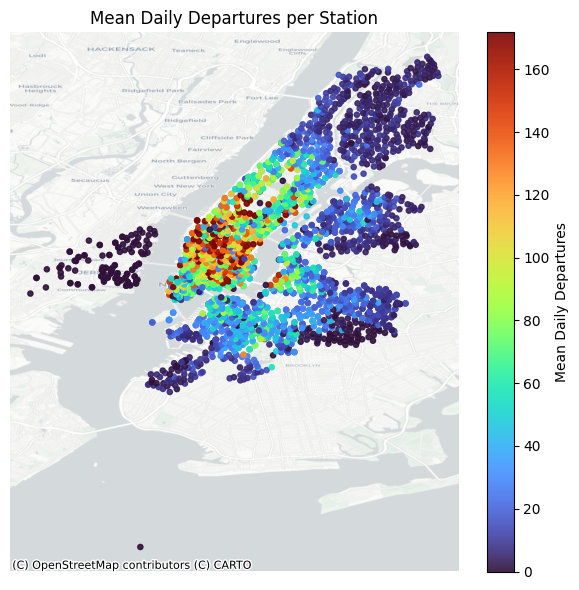

In [25]:
x, y = project_lonlat(station_avg)

fig, ax = plt.subplots(figsize=(6, 6))

vmin = station_avg["avg_daily_departures"].quantile(0.02)
vmax = station_avg["avg_daily_departures"].quantile(0.98)

sc = ax.scatter(
    x, y,
    c=station_avg["avg_daily_departures"],
    s=14,
    alpha=0.9,
    cmap="turbo",
    vmin=vmin,
    vmax=vmax
)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Mean Daily Departures per Station")
ax.set_axis_off()
plt.colorbar(sc, ax=ax, label="Mean Daily Departures")
plt.tight_layout()
plt.show()

In [26]:
YEARS = [2017, 2018, 2019, 2020, 2021, 2022]
MORNING_HOURS = [7, 8, 9]
EVENING_HOURS = [17, 18, 19]

agg_rows = []

for y in YEARS:
    p = PATHS["X_hourly_station_y"](y)

    usecols = ["ts_hour", "station_id", "hour", "departures", "lat", "lng", "is_real_station"]
    df = pd.read_parquet(p, columns=usecols)

    df["ts_hour"] = pd.to_datetime(df["ts_hour"])
    df = df[(df["ts_hour"] >= START) & (df["ts_hour"] <= END_H)].copy()

    df = df[df["hour"].isin(MORNING_HOURS + EVENING_HOURS)].copy()

    df["peak"] = np.where(df["hour"].isin(MORNING_HOURS), "morning",
                 np.where(df["hour"].isin(EVENING_HOURS), "evening", np.nan))

    tmp = (
        df.groupby(["station_id", "peak"], as_index=False)
          .agg(
              mean_hourly_departures=("departures", "mean"),
              lat=("lat", "first"),
              lng=("lng", "first"),
              is_real_station=("is_real_station", "first"),
          )
    )

    agg_rows.append(tmp)

peaks = pd.concat(agg_rows, ignore_index=True).dropna(subset=["lat", "lng"])

# Ensure only real stations even before mapping
peaks = peaks[peaks["is_real_station"] == 1].copy()

morning = peaks[peaks["peak"] == "morning"].copy()
evening = peaks[peaks["peak"] == "evening"].copy()

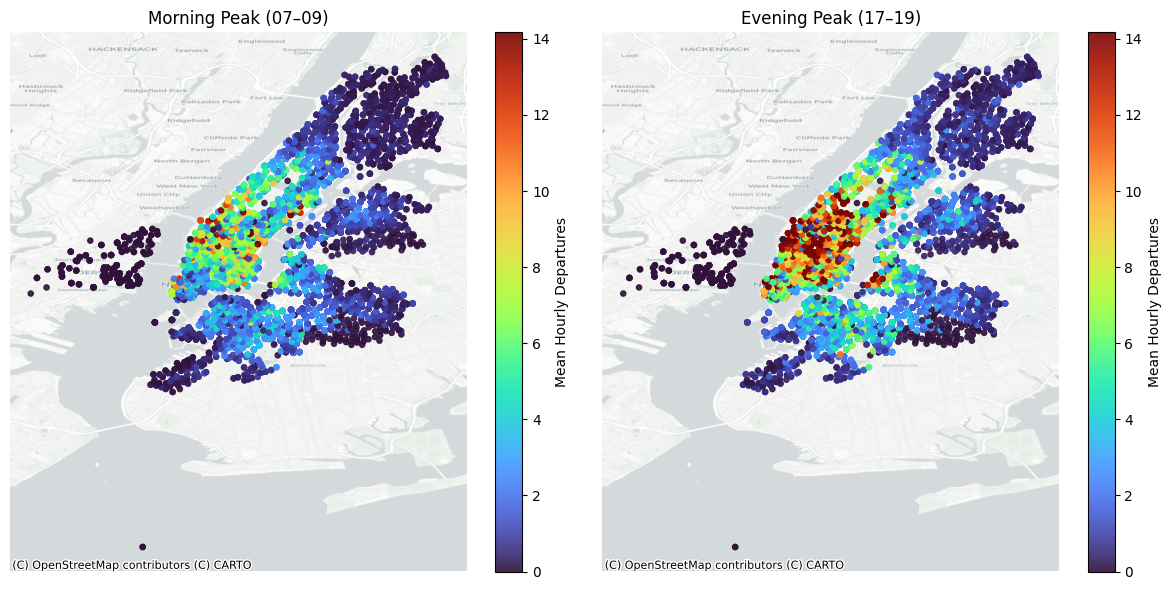

In [27]:
# Ensure morning/evening only include real stations
real_station_ids = set(station_avg["station_id"].unique())
morning = morning[morning["station_id"].isin(real_station_ids)].copy()
evening = evening[evening["station_id"].isin(real_station_ids)].copy()

# Shared vmin/vmax across both panels
combined = pd.concat([morning["mean_hourly_departures"], evening["mean_hourly_departures"]], ignore_index=True)
vmin_peak = combined.quantile(0.02)
vmax_peak = combined.quantile(0.98)

mx, my = project_lonlat(morning)
ex, ey = project_lonlat(evening)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

sc1 = axes[0].scatter(
    mx, my,
    c=morning["mean_hourly_departures"],
    s=14,
    alpha=0.9,
    cmap="turbo",
    vmin=vmin_peak,
    vmax=vmax_peak
)
cx.add_basemap(axes[0], source=cx.providers.CartoDB.Positron, zoom=12)
axes[0].set_title("Morning Peak (07–09)")
axes[0].set_axis_off()
plt.colorbar(sc1, ax=axes[0], label="Mean Hourly Departures")

sc2 = axes[1].scatter(
    ex, ey,
    c=evening["mean_hourly_departures"],
    s=14,
    alpha=0.9,
    cmap="turbo",
    vmin=vmin_peak,
    vmax=vmax_peak
)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron, zoom=12)
axes[1].set_title("Evening Peak (17–19)")
axes[1].set_axis_off()
plt.colorbar(sc2, ax=axes[1], label="Mean Hourly Departures")

plt.tight_layout()
plt.show()

In [28]:
# Build wk from station-daily X table
wk = (
    XdS.groupby(["station_id", "is_weekend"], as_index=False)
       .agg(
           avg_daily_departures=("departures", "mean"),
           lat=("lat", "first"),
           lng=("lng", "first"),
           is_real_station=("is_real_station", "first"),
       )
       .dropna(subset=["lat", "lng"])
)

# Filter invalid stations
wk = wk[wk["is_real_station"] == 1].copy()

weekday = wk[wk["is_weekend"] == 0].copy()
weekend = wk[wk["is_weekend"] == 1].copy()

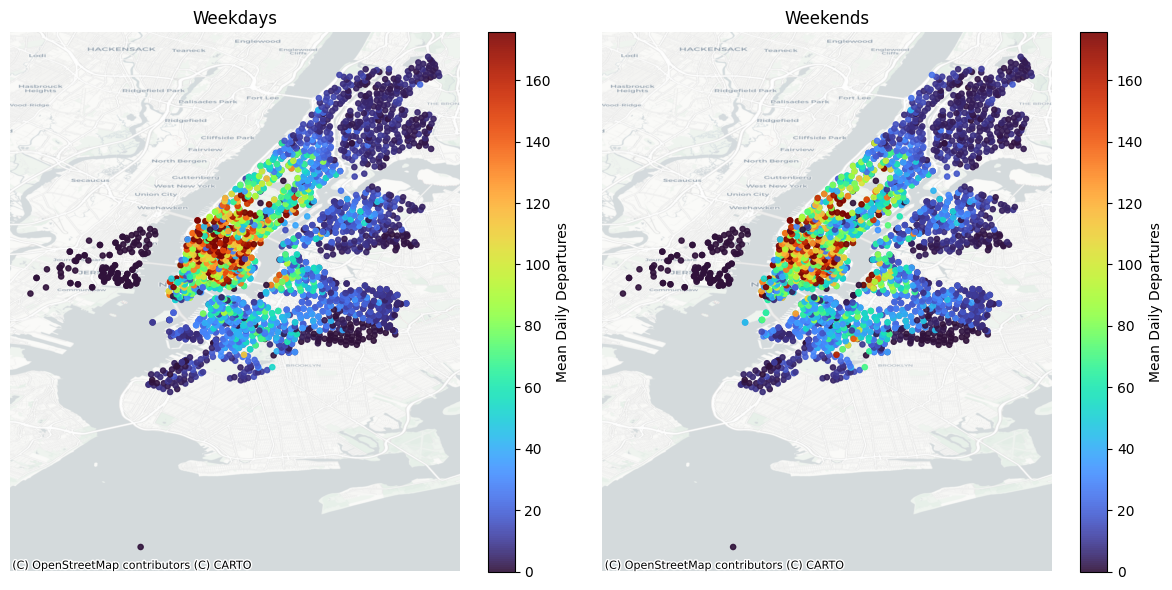

In [29]:
# Ensure weekday/weekend only include real stations
real_station_ids = set(station_avg["station_id"].unique())
wk = wk[wk["station_id"].isin(real_station_ids)].copy()

weekday = wk[wk["is_weekend"] == 0].copy()
weekend = wk[wk["is_weekend"] == 1].copy()

wx, wy = project_lonlat(weekday)
vx, vy = project_lonlat(weekend)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Shared scale across panels
combined = pd.concat([weekday["avg_daily_departures"], weekend["avg_daily_departures"]], ignore_index=True)
vmin_day = combined.quantile(0.02)
vmax_day = combined.quantile(0.98)

sc1 = axes[0].scatter(
    wx, wy,
    c=weekday["avg_daily_departures"],
    s=14,
    alpha=0.9,
    cmap="turbo",
    vmin=vmin_day,
    vmax=vmax_day
)
cx.add_basemap(axes[0], source=cx.providers.CartoDB.Positron, zoom=12)
axes[0].set_title("Weekdays")
axes[0].set_axis_off()
plt.colorbar(sc1, ax=axes[0], label="Mean Daily Departures")

sc2 = axes[1].scatter(
    vx, vy,
    c=weekend["avg_daily_departures"],
    s=14,
    alpha=0.9,
    cmap="turbo",
    vmin=vmin_day,
    vmax=vmax_day
)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron, zoom=12)
axes[1].set_title("Weekends")
axes[1].set_axis_off()
plt.colorbar(sc2, ax=axes[1], label="Mean Daily Departures")

plt.tight_layout()
plt.show()

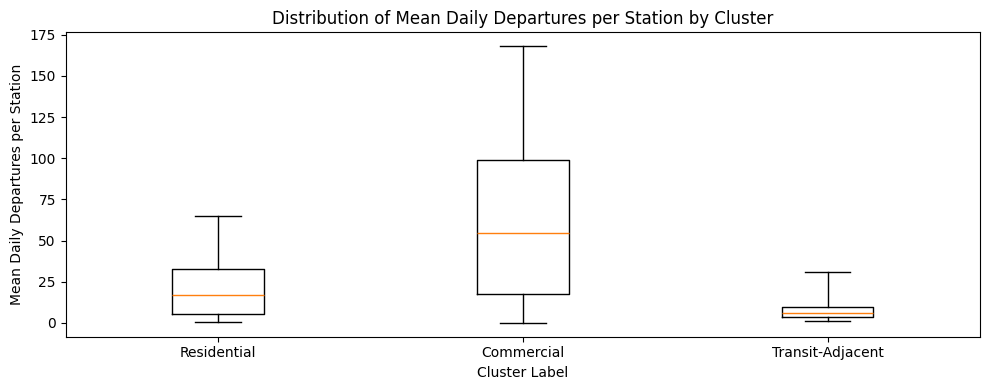

In [30]:
clusters = pd.read_parquet(PATHS["station_clusters"])[["station_id", "cluster_id", "cluster_label"]]

station_avg_cluster = station_avg.merge(clusters, on="station_id", how="inner")

LABEL_MAP = {
    "residential": "Residential",
    "commercial": "Commercial",
    "transit_adjacent": "Transit-Adjacent",
}

order = ["residential", "commercial", "transit_adjacent"]

present_keys = [k for k in order if k in station_avg_cluster["cluster_label"].unique()]
if len(present_keys) == 0:
    present_keys = sorted(station_avg_cluster["cluster_label"].unique())

data = [
    station_avg_cluster.loc[
        station_avg_cluster["cluster_label"] == k, "avg_daily_departures"
    ].to_numpy()
    for k in present_keys
]

tick_labels = [LABEL_MAP.get(k, str(k)) for k in present_keys]

fig, ax = plt.subplots(figsize=(10, 4))
ax.boxplot(data, tick_labels=tick_labels, showfliers=False, whis=(5, 95))
ax.set_title("Distribution of Mean Daily Departures per Station by Cluster")
ax.set_xlabel("Cluster Label")
ax.set_ylabel("Mean Daily Departures per Station")
plt.tight_layout()
plt.show()

In [31]:
# Load clusters
clusters = pd.read_parquet(PATHS["station_clusters"])[
    ["station_id", "cluster_label"]
]

# Build station-level static table for correlation analysis
static_cols = [
    "station_id",
    "acs_pop_density",
    "officearea_per_buffer",
    "landuse_entropy",
    "dist_nearest_bikeroute_m",
    "acs_transit_commute_share",
]

static = (
    XdS.sort_values("date")
       .groupby("station_id", as_index=False)[static_cols]
       .first()
)

df_station = (
    station_avg[["station_id", "avg_daily_departures"]]
    .merge(static, on="station_id", how="inner")
    .merge(clusters, on="station_id", how="left")
)

# Drop rows with missing predictors
predictors = [
    "acs_pop_density",
    "officearea_per_buffer",
    "landuse_entropy",
    "dist_nearest_bikeroute_m",
    "acs_transit_commute_share",
]

df_station = df_station.dropna(
    subset=["avg_daily_departures"] + predictors
).copy()

df_station.shape

(2653, 8)

In [32]:
def scatter_with_fit(
    ax,
    df,
    xcol,
    xlabel,
    ycol="avg_daily_departures",
    logx=False,
    trim=(0.01, 0.99),
    clip_y_at_zero=True
):
    d = df[[xcol, ycol]].dropna().copy()
    x = d[xcol].astype(float)
    y = d[ycol].astype(float)

    # Trim extreme x to reduce leverage
    lo, hi = x.quantile(trim[0]), x.quantile(trim[1])
    m = (x >= lo) & (x <= hi)
    x, y = x[m], y[m]

    # Scatter
    ax.scatter(x, y, s=10, alpha=0.25, color=COLOR_SCATTER, edgecolors="none")

    # Transform x if requested
    x_fit = np.log1p(x) if logx else x

    # OLS on original y
    X = sm.add_constant(x_fit)
    model = sm.OLS(y, X, missing="drop").fit()

    # Prediction grid in original x space
    x_grid = np.linspace(x.min(), x.max(), 200)
    xg_fit = np.log1p(x_grid) if logx else x_grid
    y_hat = model.predict(sm.add_constant(xg_fit))

    if clip_y_at_zero:
        y_hat = np.maximum(y_hat, 0)

    line, = ax.plot(x_grid, y_hat, linewidth=2.4, color=COLOR_SMOOTH)
    line.set_path_effects([pe.Stroke(linewidth=4.2, foreground="white"), pe.Normal()])

    # Labels and title
    ax.set_title(f"Demand vs. {xlabel}")
    ax.set_xlabel(xlabel + (" (Log Scale)" if logx else ""))
    ax.set_ylabel("Mean Daily Departures")

    # Clean axis behavior
    if clip_y_at_zero:
        ax.set_ylim(bottom=0)

    # Small annotation
    ax.text(
        0.02, 0.95,
        f"N={len(x):,}  R²={model.rsquared:.2f}",
        transform=ax.transAxes,
        va="top",
        fontsize=9
    )

    return model

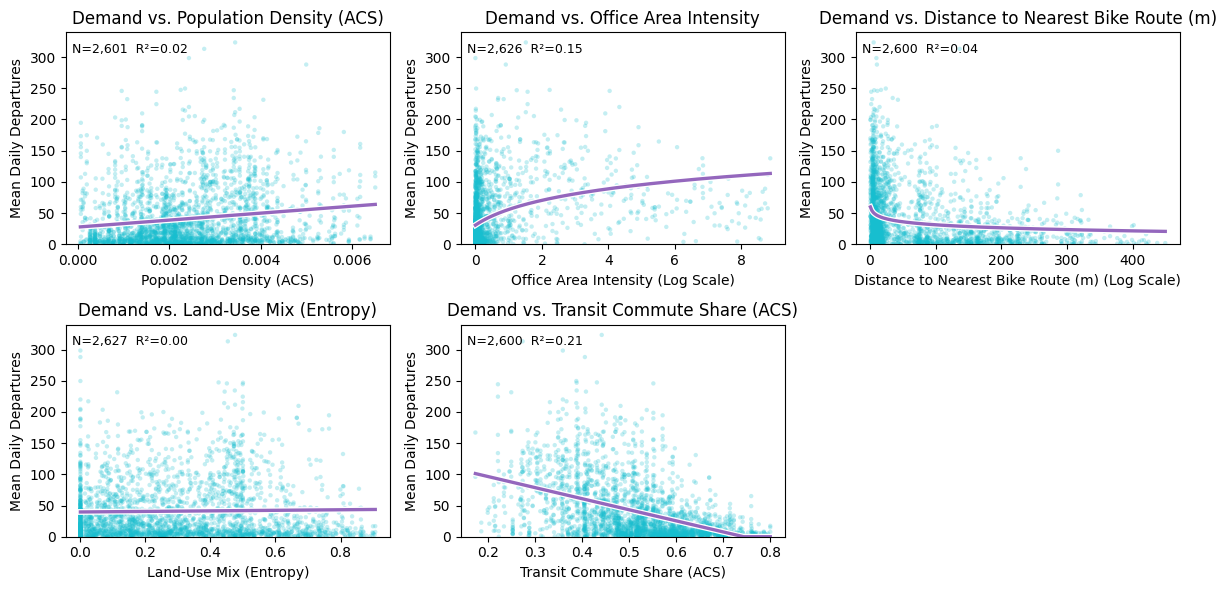

In [33]:
pairs = [
    ("acs_pop_density", "Population Density (ACS)", False),
    ("officearea_per_buffer", "Office Area Intensity", True),
    ("dist_nearest_bikeroute_m", "Distance to Nearest Bike Route (m)", True),
    ("landuse_entropy", "Land-Use Mix (Entropy)", False),
    ("acs_transit_commute_share", "Transit Commute Share (ACS)", False),
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

models = {}
for i, (xcol, xlabel, logx) in enumerate(pairs):
    ax = axes[i]
    models[xcol] = scatter_with_fit(ax, df_station, xcol=xcol, xlabel=xlabel, logx=logx)

axes[-1].axis("off")
plt.tight_layout()
plt.show()

In [34]:
y = df_station["avg_daily_departures"].astype(float)

X = df_station[[
    "acs_pop_density",
    "officearea_per_buffer",
    "landuse_entropy",
    "dist_nearest_bikeroute_m",
    "acs_transit_commute_share",
]].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X, missing="drop").fit()
print(ols.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_daily_departures   R-squared:                       0.268
Model:                              OLS   Adj. R-squared:                  0.267
Method:                   Least Squares   F-statistic:                     194.0
Date:                  Thu, 29 Jan 2026   Prob (F-statistic):          1.74e-176
Time:                          10:35:52   Log-Likelihood:                -13552.
No. Observations:                  2653   AIC:                         2.712e+04
Df Residuals:                      2647   BIC:                         2.715e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

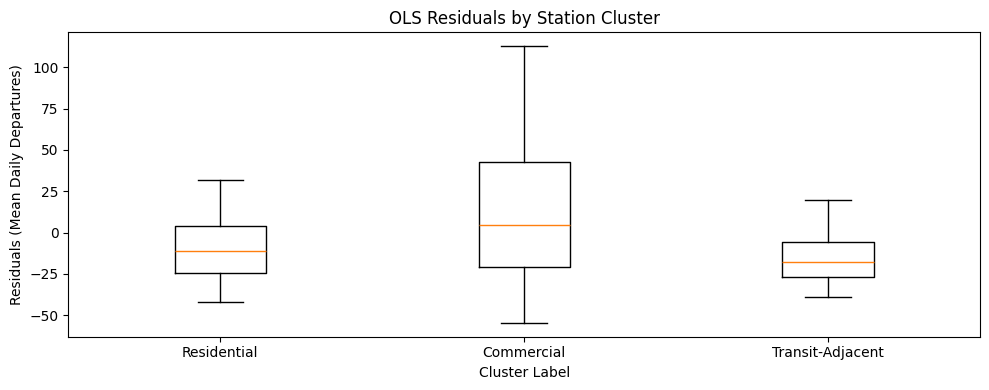

In [35]:
df_station["ols_resid"] = ols.resid

LABEL_MAP = {
    "residential": "Residential",
    "commercial": "Commercial",
    "transit_adjacent": "Transit-Adjacent",
}

order = ["residential", "commercial", "transit_adjacent"]

present_keys = [
    k for k in order
    if k in df_station["cluster_label"].dropna().unique()
]

if len(present_keys) == 0:
    present_keys = sorted(df_station["cluster_label"].dropna().unique())

data = [
    df_station.loc[df_station["cluster_label"] == k, "ols_resid"].to_numpy()
    for k in present_keys
]

tick_labels = [LABEL_MAP.get(k, str(k)) for k in present_keys]

fig, ax = plt.subplots(figsize=(10, 4))
ax.boxplot(
    data,
    tick_labels=tick_labels,
    showfliers=False,
    whis=(5, 95),
)

ax.set_title("OLS Residuals by Station Cluster")
ax.set_xlabel("Cluster Label")
ax.set_ylabel("Residuals (Mean Daily Departures)")

plt.tight_layout()
plt.show()

In [36]:
CLUSTER_COLORS = {
    "residential": "#1F77B4",
    "commercial": "#2CA02C",
    "transit_adjacent": "#9467BD"
}

#### Cluster-colored station map (with basemap)

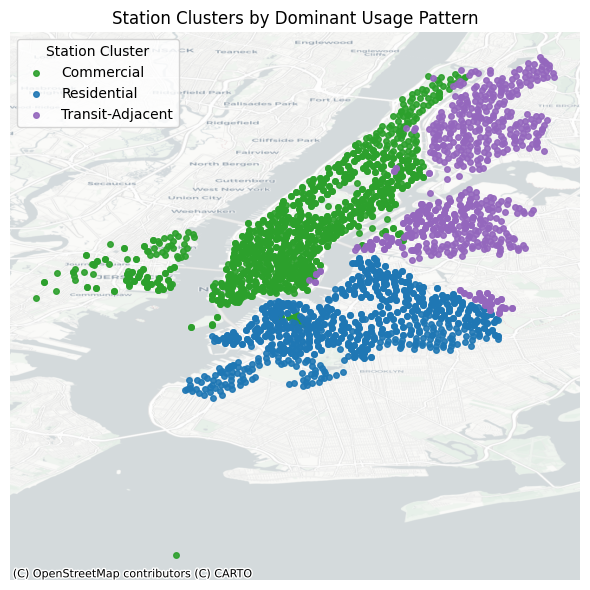

In [37]:
CLUSTER_LABEL_MAP = {
    "residential": "Residential",
    "commercial": "Commercial",
    "transit_adjacent": "Transit-Adjacent",
}

station_cluster_map = (
    station_avg
    .merge(clusters[["station_id", "cluster_label"]], on="station_id", how="left")
    .dropna(subset=["cluster_label"])
)

cx_, cy_ = project_lonlat(station_cluster_map)

fig, ax = plt.subplots(figsize=(6, 6))

for cl, g in station_cluster_map.groupby("cluster_label"):
    mask = station_cluster_map["cluster_label"] == cl
    ax.scatter(
        cx_[mask],
        cy_[mask],
        s=16,
        alpha=0.9,
        color=CLUSTER_COLORS.get(cl, "#999999"),
        label=CLUSTER_LABEL_MAP.get(cl, cl.replace("_", " ").title())
    )

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Station Clusters by Dominant Usage Pattern")
ax.set_axis_off()
ax.legend(
    loc="upper left",
    title="Station Cluster"
)
plt.tight_layout()
plt.show()

In [38]:
year = 2019

df_h_2019 = pd.read_parquet(
    PATHS["X_hourly_station_y"](year),
    columns=["ts_hour", "station_id", "departures", "is_real_station"]
)

df_h_2019 = df_h_2019[df_h_2019["is_real_station"] == 1].copy()

print("Rows:", len(df_h_2019))
print("Stations:", df_h_2019["station_id"].nunique())
print("Zero share (observed station-hours):", (df_h_2019["departures"] == 0).mean())
print("Max departures:", df_h_2019["departures"].max())

Rows: 8418360
Stations: 961
Zero share (observed station-hours): 0.7163723100461372
Max departures: 181


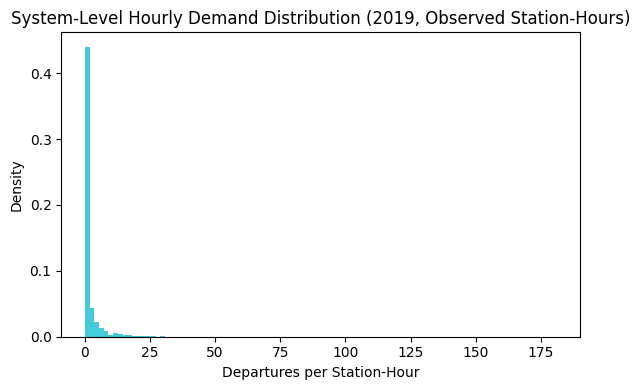

Zero share (station-hour): 0.716


In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(
    df_h_2019["departures"],
    bins=100,
    density=True,
    alpha=0.8,
    color=COLOR_SCATTER
)

ax.set_title("System-Level Hourly Demand Distribution (2019, Observed Station-Hours)")
ax.set_xlabel("Departures per Station-Hour")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

zero_share = (df_h_2019["departures"] == 0).mean()
print(f"Zero share (station-hour): {zero_share:.3f}")

df_h rows after real-station filter: 8418360
unique stations: 961
overall zero share: 0.7163723100461372
Rows for station 519: 8760
Rows for station 488: 8760


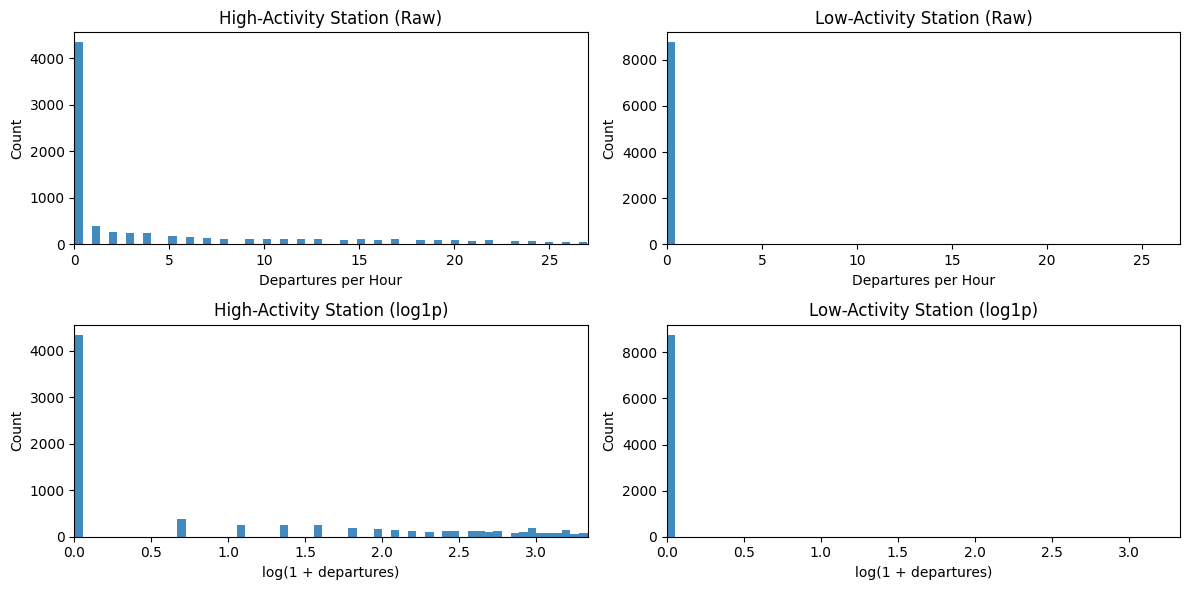

Zero share (high station): 0.49554794520547946
Zero share (low station): 0.9996575342465753


In [40]:
year = 2019

df_h = pd.read_parquet(
    PATHS["X_hourly_station_y"](year),
    columns=["station_id", "departures", "is_real_station"]
).copy()

# Robust real-station filter
flag = df_h["is_real_station"]
if pd.api.types.is_bool_dtype(flag):
    real_mask = flag.fillna(False)
else:
    real_mask = pd.to_numeric(flag, errors="coerce").fillna(0).astype(int).eq(1)

df_h = df_h[real_mask].copy()

# Ensure numeric
df_h["departures"] = pd.to_numeric(df_h["departures"], errors="coerce").fillna(0)

# station_id dtype normalization
df_h["station_id"] = pd.to_numeric(df_h["station_id"], errors="coerce")
df_h = df_h.dropna(subset=["station_id"]).copy()
df_h["station_id"] = df_h["station_id"].astype(int)

print("df_h rows after real-station filter:", len(df_h))
print("unique stations:", df_h["station_id"].nunique())
print("overall zero share:", (df_h["departures"] == 0).mean())

station_hourly_mean = (
    df_h.groupby("station_id", as_index=False)["departures"].mean()
        .rename(columns={"departures": "mean_hourly"})
)

hi_station = int(station_hourly_mean.sort_values("mean_hourly").iloc[-1]["station_id"])
lo_station = int(
    station_hourly_mean[station_hourly_mean["mean_hourly"] > 0]
    .sort_values("mean_hourly")
    .iloc[0]["station_id"]
)

xmax = df_h["departures"].quantile(0.995)
xmax_int = int(np.ceil(xmax))
log_xmax = np.log1p(max(xmax_int, 1))

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for sid, col, label in [(hi_station, 0, "High-Activity Station"),
                        (lo_station, 1, "Low-Activity Station")]:
    g = df_h[df_h["station_id"] == sid].copy()
    print(f"Rows for station {sid}:", len(g))

    axes[0, col].hist(g["departures"], bins=60, range=(0, xmax_int), alpha=0.85)
    axes[0, col].set_title(f"{label} (Raw)")
    axes[0, col].set_xlabel("Departures per Hour")
    axes[0, col].set_ylabel("Count")
    axes[0, col].set_xlim(0, xmax_int)

    axes[1, col].hist(np.log1p(g["departures"]), bins=60, range=(0, log_xmax), alpha=0.85)
    axes[1, col].set_title(f"{label} (log1p)")
    axes[1, col].set_xlabel("log(1 + departures)")
    axes[1, col].set_ylabel("Count")
    axes[1, col].set_xlim(0, log_xmax)

plt.tight_layout()
plt.show()

print("Zero share (high station):", (df_h[df_h["station_id"] == hi_station]["departures"] == 0).mean())
print("Zero share (low station):",  (df_h[df_h["station_id"] == lo_station]["departures"] == 0).mean())

In [41]:
# Add authoritative system targets
PATHS.update({
    "y_daily_system":  BASE / "targets/system/y_daily_system.parquet",
    "y_hourly_system": BASE / "targets/system/y_hourly_system.parquet",
    "cal_daily":       BASE / "calendar/calendar_daily.parquet",
    "cal_hourly":      BASE / "calendar/calendar_hourly.parquet",
})

Zero days (authoritative system daily): 5
Min trips: 0


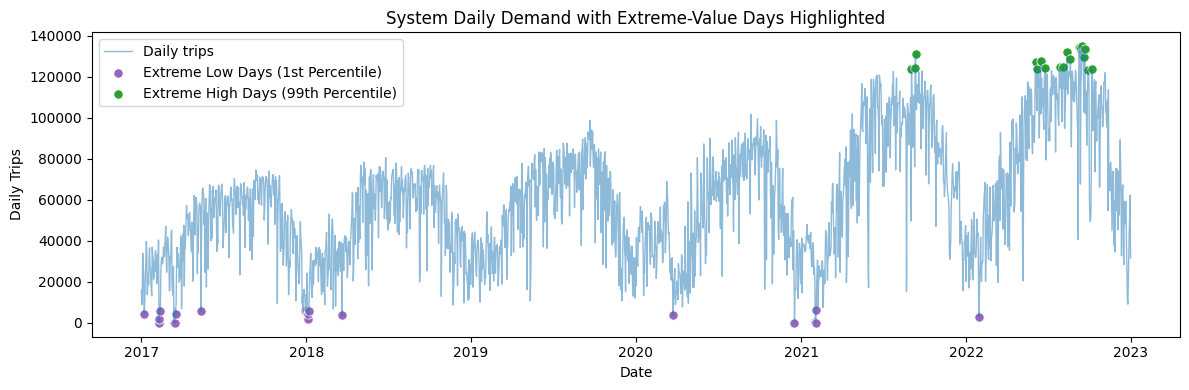

In [42]:
sys_daily = pd.read_parquet(PATHS["y_daily_system"]).copy()
sys_daily["date"] = pd.to_datetime(sys_daily["date"])
sys_daily = sys_daily[(sys_daily["date"] >= START) & (sys_daily["date"] <= END.normalize())].copy()

print("Zero days (authoritative system daily):", (sys_daily["trips"] == 0).sum())
print("Min trips:", sys_daily["trips"].min())

q_low  = sys_daily["trips"].quantile(0.01)
q_high = sys_daily["trips"].quantile(0.99)

extreme_low  = sys_daily[sys_daily["trips"] <= q_low].copy()
extreme_high = sys_daily[sys_daily["trips"] >= q_high].copy()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    sys_daily["date"],
    sys_daily["trips"],
    color=COLOR_TS,
    linewidth=1.0,
    alpha=0.50,
    label="Daily trips"
)

ax.scatter(
    extreme_low["date"],
    extreme_low["trips"],
    s=45,
    color=C_PURPLE,
    edgecolor="white",
    linewidth=0.6,
    label="Extreme Low Days (1st Percentile)"
)

ax.scatter(
    extreme_high["date"],
    extreme_high["trips"],
    s=45,
    color=C_GREEN,
    edgecolor="white",
    linewidth=0.6,
    label="Extreme High Days (99th Percentile)"
)

ax.set_title("System Daily Demand with Extreme-Value Days Highlighted")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Trips")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

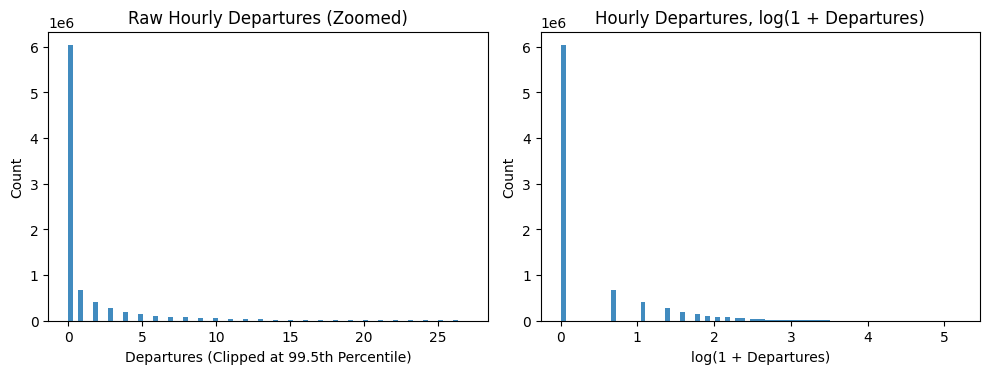

In [43]:
xmax = df_h["departures"].quantile(0.995)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df_h["departures"], bins=80, range=(0, xmax), density=False, alpha=0.85)
axes[0].set_title("Raw Hourly Departures (Zoomed)")
axes[0].set_xlabel("Departures (Clipped at 99.5th Percentile)")
axes[0].set_ylabel("Count")

axes[1].hist(np.log1p(df_h["departures"]), bins=80, density=False, alpha=0.85)
axes[1].set_title("Hourly Departures, log(1 + Departures)")
axes[1].set_xlabel("log(1 + Departures)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()